In [1]:
from rdkit import Chem
import numpy as np
import pandas as pd
from IPython.display import display
import tqdm

# Load simulator data

In [2]:
dataset = pd.read_csv("/home/abhor/Desktop/repos/ReactionRL/datasets/my_uspto/action_dataset.csv", index_col=0)

In [3]:
dataset

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
0,CON(C)C(=O)c1ccc(O)nc1,CC(C)CC(=O)c1ccc(O)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][CH:1]([CH3:2])[CH2:3][C:4](=[O:5])[c:6...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][CH:1]([CH3:2])[CH3:3],2,3,[[1.0]],[[1.0]],0
25624,CON(C)C(=O)c1ccc(Cl)nc1N,COc1cc(C)c(F)cc1C(=O)c1ccc(Cl)nc1N,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][O:1][c:2]1[cH:3][c:4]([CH3:5])[c:6]([F...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][O:1][c:2]1[cH:3][c:4]([CH3:5])[c:6]([F...,2,9,[[1.0]],[[1.0]],0
26279,CON(C)C(=O)c1ccc(Cl)nc1,O=Cc1ccc(Cl)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[H:0],[CH3:0][O:1][NH:2][CH3:3],[H:0],2,0,[[1.0]],[],0
27114,CON(C)C(=O)c1cccnc1Cl,CC(=O)c1cccnc1Cl,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][C:1](=[O:2])[c:3]1[cH:4][cH:5][cH:6][n...,[CH3:0][O:1][NH:2][CH3:3],[CH4:0],2,0,[[1.0]],[[1.0]],0
68734,CON(C)C(=O)c1ccc(Cl)nc1,COc1ccccc1C(=O)c1ccc(Cl)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][O:1][c:2]1[cH:3][cH:4][cH:5][cH:6][c:7...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][O:1][c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1,2,7,[[1.0]],[[1.0]],0
...,...,...,...,...,...,...,...,...,...,...,...
448339,OCCC(F)(F)C(F)(F)C(F)(F)F,O=P([O-])(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F,[OH:0][CH2:1][CH2:2][C:3]([F:4])([F:5])[C:6]([...,[O:0]=[P:1]([O-:2])([C:3]([F:4])([F:5])[CH3:6]...,[OH:0][CH2:1][CH2:2][CH:3]([F:4])[F:5],[O:0]=[PH:1]([O-:2])[C:7]([F:8])([F:9])[C:10](...,3,1,[[1.0]],[[1.0]],393801
448392,CCNC(=O)n1nc(N)c2cc(C(F)(F)F)ccc21,CCN=C=O,[CH3:0][NH:1][C:2](=[O:3])[n:4]1[n:5][c:6]([NH...,[CH3:0][N:1]=[C:2]=[O:3],[CH:2](=[O:3])[n:4]1[n:5][c:6]([NH2:7])[c:8]2[...,[CH2:2]=[O:3],2,2,[[1.0]],[[2.0]],393838
448417,O=P(C(F)(F)C(F)(F)F)(C(F)(F)C(F)(F)F)C(F)(F)C(...,O=P([O-])(C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)F,[O:0]=[P:1]([CH3:2])([CH3:3])[C:4]([F:5])([F:6...,[O:0]=[P:1]([O-:2])([CH3:3])[CH3:4],[CH:4]([F:5])([F:6])[C:7]([F:8])([F:9])[F:10],[O-:2],4,2,[[1.0]],[[1.0]],393859
448458,CCOc1ccc(C(C)(C)COCc2ccc(F)c(Oc3ccccc3)c2)cc1,CCOc1ccc(C(C)(C)CO)cc1,[CH3:0][O:1][CH2:2][c:3]1[cH:4][cH:5][c:6]([F:...,[H:0],[CH3:2][c:3]1[cH:4][cH:5][c:6]([F:7])[c:8]([O:...,[H:0],2,0,[[1.0]],[],393888


# Indexing 

First, we create index for rsub to make for faster searching.

Searching will be based on rsub because the action searching algorithm cannot create rsigs. rsigs will be used for substructure matching.

In [4]:
import pynauty
import networkx as nx

In [5]:
# Fetch the rsubs using the clusters
rsig_cluster_to_rsub_d = {}
for cluster_id in dataset["rsig_clusters"].unique():
    cluster_df = dataset[dataset["rsig_clusters"] == cluster_id]
    rsub  = Chem.MolFromSmiles(cluster_df.iloc[0]["rsub"])
    rsig_cluster_to_rsub_d[cluster_id] = rsub
    
print(f"There are {len(rsig_cluster_to_rsub_d)} unique (rsigs)rsubs.")

There are 43861 unique (rsigs)rsubs.


In [6]:
# Get atom frequency for making rings in the signature
atom_frequency = {}

for i in tqdm.tqdm(range(dataset.shape[0]), total=dataset.shape[0]):
    atoms = list(Chem.MolFromSmiles(dataset.iloc[i]["reactants"]).GetAtoms()) + list(Chem.MolFromSmiles(dataset.iloc[i]["products"]).GetAtoms())
    atom_nums, counts = np.unique(list(map(lambda x: x.GetAtomicNum(), atoms)), return_counts=True)
    for num, cnt in zip(atom_nums, counts):
        if num not in atom_frequency:
            atom_frequency[num] = cnt
        else:
            atom_frequency[num] += cnt

mapping = list(range(1, 50))
mapping.remove(2)
atom_to_freq_order = {x: mapping[i] for i, (_, x) in enumerate(sorted(zip(list(atom_frequency.values()), list(atom_frequency.keys())))[::-1])}

100%|███████████████████████████████████████████████████████████████████| 191108/191108 [02:19<00:00, 1374.17it/s]


In [7]:
# For each rsig, genearate a certificate
def get_mol_certificate(mol):
    adj_mat = Chem.GetAdjacencyMatrix(mol)

    # Create a ring for each atom with size = atomic_num
    atom_nums = np.array([atom_to_freq_order[atom.GetAtomicNum()] for atom in list(mol.GetAtoms())])
    mat_list = []
    for atn in atom_nums:
        new_mat = np.zeros(shape=(atn, atn), dtype=np.int8)
        for i in range(atn):
            new_mat[i, (i+1)%atn] = 1
        mat_list.append(new_mat)

    # conbine the rings into a new adj mat
    new_adj_mat = np.zeros(shape=(sum(atom_nums), sum(atom_nums)), dtype=np.int8)
    idx = 0
    for i in range(len(atom_nums)):
        new_adj_mat[idx:idx+atom_nums[i], idx:idx+atom_nums[i]] = mat_list[i]
        idx += atom_nums[i]

    # add original last connections
    idx = 0
    for i, a_i in enumerate(np.cumsum(atom_nums)):
        for j, a_j in enumerate(np.cumsum(atom_nums)):
            new_adj_mat[a_i-1, a_j-1] = adj_mat[i, j]

    adj_mat = new_adj_mat
    
    # convert adj matrix to adj dict
    adj_dict = {}
    for i, row in enumerate(adj_mat):
        adj_dict[i] = [x for x, j in enumerate(row) if j]
        
    # get graph
    G = pynauty.Graph(len(adj_dict), directed=False, adjacency_dict=adj_dict)#, vertex_coloring=coloring)
    
    # return certificate
    return pynauty.certificate(G)
        
certificate_to_cluster_id_dict = {}
for _id in tqdm.tqdm(rsig_cluster_to_rsub_d):
    C = get_mol_certificate(rsig_cluster_to_rsub_d[_id])
    if C in certificate_to_cluster_id_dict:
        certificate_to_cluster_id_dict[C].append(_id)
    else:
        certificate_to_cluster_id_dict[C] = [_id]

100%|█████████████████████████████████████████████████████████████████████| 43861/43861 [00:06<00:00, 7120.83it/s]


138
[0, 7222, 24719, 14436, 181219, 358364, 89401, 165672, 2123, 10525, 41437, 77056, 172019, 259883, 351713, 161693, 185148, 101652, 110135, 111987, 212774, 355145, 35384, 308531, 160632, 233029, 209769, 259918, 89905, 150773, 1047, 1300, 36259, 123933, 447, 33204, 55341, 116281, 494, 298142, 5627, 40796, 135484, 354785, 366344, 49189, 104500, 227782, 362169, 12862, 32596, 83525, 72281, 195494, 209198, 1310, 17701, 100663, 353182, 36736, 42267, 117181, 145544, 176441, 4244, 51450, 30043, 78216, 120498, 228275, 11419, 56794, 115506, 246680, 254933, 1992, 5947, 103669, 188835, 236008, 60130, 86550, 213614, 241350, 29319, 50568, 94405, 313245, 154804, 267803, 17798, 242046, 259187, 7116, 248567, 252729, 229117, 5958, 74251, 384996, 82829, 79289, 65105, 147784, 213924, 92255, 119184, 15653, 293233, 10197, 47187, 253017, 14205, 76162, 301373, 36173, 315280, 21245, 23867, 88560, 112840, 222759, 117811, 120098, 158385, 324854, 186074, 133217, 62032, 220870, 307558, 63537, 125992, 183878, 334

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
0,CON(C)C(=O)c1ccc(O)nc1,CC(C)CC(=O)c1ccc(O)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][CH:1]([CH3:2])[CH2:3][C:4](=[O:5])[c:6...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][CH:1]([CH3:2])[CH3:3],2,3,[[1.0]],[[1.0]],0
25624,CON(C)C(=O)c1ccc(Cl)nc1N,COc1cc(C)c(F)cc1C(=O)c1ccc(Cl)nc1N,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][O:1][c:2]1[cH:3][c:4]([CH3:5])[c:6]([F...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][O:1][c:2]1[cH:3][c:4]([CH3:5])[c:6]([F...,2,9,[[1.0]],[[1.0]],0
26279,CON(C)C(=O)c1ccc(Cl)nc1,O=Cc1ccc(Cl)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[H:0],[CH3:0][O:1][NH:2][CH3:3],[H:0],2,0,[[1.0]],[],0
27114,CON(C)C(=O)c1cccnc1Cl,CC(=O)c1cccnc1Cl,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][C:1](=[O:2])[c:3]1[cH:4][cH:5][cH:6][n...,[CH3:0][O:1][NH:2][CH3:3],[CH4:0],2,0,[[1.0]],[[1.0]],0
68734,CON(C)C(=O)c1ccc(Cl)nc1,COc1ccccc1C(=O)c1ccc(Cl)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][O:1][c:2]1[cH:3][cH:4][cH:5][cH:6][c:7...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][O:1][c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1,2,7,[[1.0]],[[1.0]],0
79413,CON(C)C(=O)c1ccc(N2CCN(C(=O)OC(C)(C)C)CC2)nc1,CC(O)c1ccc(N2CCN(C(=O)OC(C)(C)C)CC2)nc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][CH:1]([OH:2])[c:3]1[cH:4][cH:5][cH:6][...,[CH3:0][O:1][N:2]([CH3:3])[CH:4]=[O:5],[CH3:0][CH2:1][OH:2],4,1,[[1.0]],[[1.0]],0
103109,CON(C)C(=O)c1cc(Br)cnc1N,Nc1ncc(Br)cc1C(=O)c1ccccc1OC(F)(F)F,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[cH:0]1[n:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O:...,[CH3:0][O:1][NH:2][CH3:3],[cH:8]1[cH:9][cH:10][cH:11][cH:12][c:13]1[O:14...,2,8,[[1.0]],[[1.0]],0
119790,CON(C)C(=O)c1ccc(Cl)nc1,O=C(c1ccc(Cl)nc1)c1cccc(F)c1F,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[O:0]=[C:1]([c:2]1[cH:3][cH:4][cH:5][n:6][cH:7...,[CH3:0][O:1][NH:2][CH3:3],[cH:8]1[cH:9][cH:10][cH:11][c:12]([F:13])[c:14...,2,8,[[1.0]],[[1.0]],0
136108,CON(C)C(=O)c1ccc(Cl)nc1N,Nc1nc(Cl)ccc1C(=O)c1c(F)cccc1F,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[cH:0]1[n:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O:...,[CH3:0][O:1][NH:2][CH3:3],[cH:8]1[c:9]([F:10])[cH:11][cH:12][cH:13][c:14...,2,8,[[1.0]],[[1.0]],0
150906,CON(C)C(=O)c1cc(Br)cnc1N,Nc1ncc(Br)cc1C(=O)c1cccc(F)n1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[cH:0]1[n:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O:...,[CH3:0][O:1][NH:2][CH3:3],[cH:8]1[cH:9][cH:10][cH:11][c:12]([F:13])[n:14]1,2,8,[[1.0]],[[1.0]],0


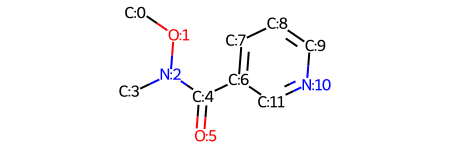

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
8174,CCc1nc(C(F)(F)F)ccc1C(=O)N(C)OC,CCc1nc(C(F)(F)F)ccc1C=O,[cH:0]1[n:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O:...,[H:0],[NH:8]([CH3:9])[O:10][CH3:11],[H:0],8,0,[[1.0]],[],7222


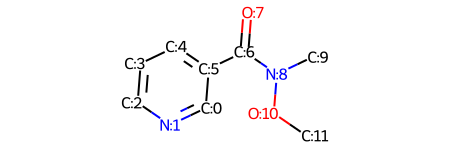

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
28119,CCOc1cncc(C(=O)N(C)OC)c1,CCOc1cncc(C=O)c1,[cH:0]1[cH:1][n:2][cH:3][c:4]([C:5](=[O:6])[N:...,[H:0],[NH:7]([CH3:8])[O:9][CH3:10],[H:0],7,0,[[1.0]],[],24719


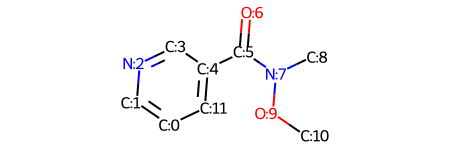

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
16397,CON(C)C(=O)c1cc(NS(=O)(=O)c2ccc(Cl)cc2Cl)ncc1S...,O=Cc1cc(NS(=O)(=O)c2ccc(Cl)cc2Cl)ncc1Sc1ccc(S(...,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[H:0],[CH3:0][O:1][NH:2][CH3:3],[H:0],2,0,[[1.0]],[[1.0]],14436
21011,CON(C)C(=O)c1ccncc1,COc1cccc(C(=O)c2ccncc2)c1OC,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][O:1][c:2]1[cH:3][cH:4][cH:5][c:6]([C:7...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][O:1][c:2]1[cH:3][cH:4][cH:5][cH:6][c:1...,2,6,[[1.0]],[[1.0]],14436
23151,CON(C)C(=O)c1ccnc(NC(=O)OC(C)(C)C)c1,CC(=O)c1ccnc(NC(=O)OC(C)(C)C)c1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][C:1](=[O:2])[c:3]1[cH:4][cH:5][n:6][cH...,[CH3:0][O:1][NH:2][CH3:3],[CH4:0],2,0,[[1.0]],[[1.0]],14436
125331,CON(C)C(=O)c1cc(NS(=O)(=O)c2ccc(Cl)cc2Cl)ncc1S...,CCCC(=O)c1cc(NS(=O)(=O)c2ccc(Cl)cc2Cl)ncc1Sc1c...,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][CH2:1][CH2:2][C:3](=[O:4])[c:5]1[cH:6]...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][CH2:1][CH3:2],2,2,[[1.0]],[[1.0]],14436
392499,CON(C)C(=O)c1ccncc1,CC(C)(C#CC(=O)c1ccncc1)O[Si](C)(C)C,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][C:1]([CH3:2])([C:3]#[C:4][C:5](=[O:6])...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][C:1]([CH3:2])([C:3]#[CH:4])[O:13][Si:1...,2,4,[[1.0]],[[1.0]],14436


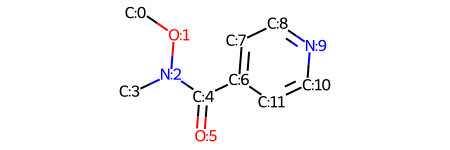

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
206267,CCN(CC)C(=O)c1c(C(=O)N(C)OC)ccnc1OC,CCN(CC)C(=O)c1c(C(=O)c2cc3cnccc3n2S(=O)(=O)c2c...,[cH:0]1[c:1]([C:2](=[O:3])[N:4]([CH3:5])[O:6][...,[cH:0]1[c:1]([C:2](=[O:3])[c:4]2[cH:5][c:6]3[c...,[NH:4]([CH3:5])[O:6][CH3:7],[cH:4]1[cH:5][c:6]2[cH:7][n:8][cH:9][cH:10][c:...,4,4,[[1.0]],[[1.0]],181219


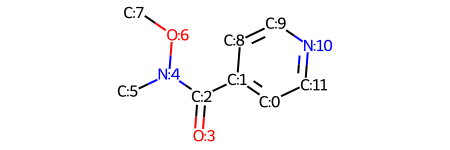

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
408005,COc1cc(C(=O)N(C)OC)cc(N=C(c2ccccc2)c2ccccc2)n1,COc1cc(C(=O)c2cn(C(C)C)c3ncnc(Cl)c23)cc(N=C(c2...,[cH:0]1[cH:1][c:2]([C:3](=[O:4])[N:5]([CH3:6])...,[cH:0]1[cH:1][c:2]([C:3](=[O:4])[c:5]2[cH:6][n...,[NH:5]([CH3:6])[O:7][CH3:8],[cH:5]1[cH:6][n:7]([CH:8]([CH3:9])[CH3:10])[c:...,5,5,[[1.0]],[[1.0]],358364


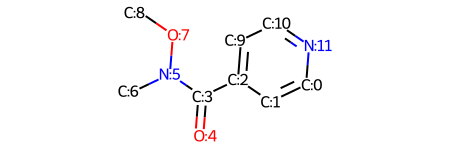

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
101601,CON(C)C(=O)c1ncc(Br)cc1F,O=Cc1ncc(Br)cc1F,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[H:0],[CH3:0][O:1][NH:2][CH3:3],[H:0],2,0,[[1.0]],[[1.0]],89401
106923,CON(C)C(=O)c1cccc(C)n1,Cc1ccc(CC(=O)c2cccc(C)n2)cc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][c:1]1[cH:2][cH:3][c:4]([CH2:5][C:6](=[...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][c:1]1[cH:2][cH:3][c:4]([CH3:5])[cH:14]...,2,5,[[1.0]],[[1.0]],89401
175514,CON(C)C(=O)c1ncccc1CSc1cccc(Cl)c1,CN1CCC(C(=O)c2ncccc2CSc2cccc(Cl)c2)CC1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][N:1]1[CH2:2][CH2:3][CH:4]([C:5](=[O:6]...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][N:1]1[CH2:2][CH2:3][CH2:4][CH2:13][CH2...,2,4,[[1.0]],[[1.0]],89401
284428,CON(C)C(=O)c1cc(Cl)ccn1,CC(=O)c1cc(Cl)ccn1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][C:1](=[O:2])[c:3]1[cH:4][cH:5][cH:6][c...,[CH3:0][O:1][NH:2][CH3:3],[CH4:0],2,0,[[1.0]],[[1.0]],89401
433597,CON(C)C(=O)c1ncc(Cl)cc1NS(=O)(=O)c1ccc(Cl)c(C(...,O=C(c1ncc(Cl)cc1NS(=O)(=O)c1ccc(Cl)c(C(F)(F)F)...,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[O:0]=[C:1]([c:2]1[n:3][cH:4][cH:5][cH:6][cH:7...,[CH3:0][O:1][NH:2][CH3:3],[cH:8]1[cH:9][cH:10][n:11][c:12]2[nH:13][n:14]...,2,8,[[1.0]],[[1.0]],89401


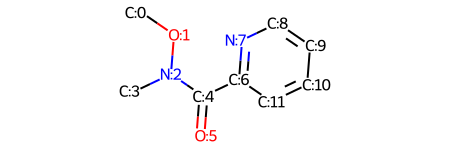

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
188466,COc1cccnc1C(=O)N(C)OC,COc1cccnc1C(=O)c1cc(Br)cnc1F,[cH:0]1[cH:1][cH:2][cH:3][n:4][c:5]1[C:6](=[O:...,[cH:0]1[cH:1][cH:2][cH:3][n:4][c:5]1[C:6](=[O:...,[NH:8]([CH3:9])[O:10][CH3:11],[cH:8]1[cH:9][c:10]([Br:11])[cH:12][n:13][c:14...,8,8,[[1.0]],[[1.0]],165672


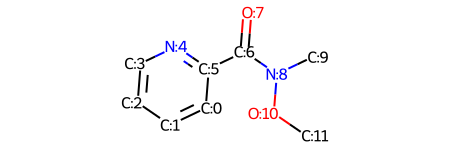

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
2431,CON(C)C(=O)c1ccc(CO[Si](C(C)C)(C(C)C)C(C)C)cc1,CC(C)[Si](OCc1ccc(C(=O)Cc2ccncc2)cc1)(C(C)C)C(C)C,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[cH:0]1[cH:1][cH:2][c:3]([C:4](=[O:5])[CH2:6][...,[CH3:0][O:1][NH:2][CH3:3],[CH3:6][c:7]1[cH:8][cH:9][n:10][cH:11][cH:12]1,2,6,[[1.0]],[[1.0]],2123
102798,CON(C)C(=O)c1ccc(OCc2ccc3ccccc3n2)c(F)c1F,O=C(Cc1ccncc1)c1ccc(OCc2ccc3ccccc3n2)c(F)c1F,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[O:0]=[C:1]([CH2:2][c:3]1[cH:4][cH:5][n:6][cH:...,[CH3:0][O:1][NH:2][CH3:3],[CH3:2][c:3]1[cH:4][cH:5][n:6][cH:7][cH:8]1,2,2,[[1.0]],[[1.0]],2123
2520,CON(C)C(=O)c1cccc(F)c1C1CCN(C(=O)OC(C)(C)C)CC1,CC(C)(C)OC(=O)N1CCC(c2c(F)cccc2C=O)CC1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[H:0],[CH3:0][O:1][NH:2][CH3:3],[H:0],2,0,[[1.0]],[],2123
2639,CON(C)C(=O)c1ccc(Br)cc1Cl,CC(=O)c1ccc(Br)cc1Cl,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][C:1](=[O:2])[c:3]1[cH:4][cH:5][cH:6][c...,[CH3:0][O:1][NH:2][CH3:3],[CH4:0],2,0,[[1.0]],[[1.0]],2123
172356,CON(C)C(=O)c1cc(NC(C)=O)cc(S(F)(F)(F)(F)F)c1,CC(=O)Nc1cc(C(C)=O)cc(S(F)(F)(F)(F)F)c1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[cH:0]1[cH:1][c:2]([C:3]([CH3:4])=[O:5])[cH:6]...,[CH3:0][O:1][NH:2][CH3:3],[CH4:4],2,4,[[1.0]],[[1.0]],2123
...,...,...,...,...,...,...,...,...,...,...,...
424156,CON(C)C(=O)c1ccc(Cl)cc1,CCOC(=O)C1CCCC(C(=O)c2ccc(Cl)cc2)C1=O,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH3:0][CH2:1][O:2][C:3](=[O:4])[CH:5]1[CH2:6]...,[CH3:0][O:1][NH:2][CH3:3],[CH3:0][CH2:1][O:2][C:3](=[O:4])[CH:5]1[CH2:6]...,2,9,[[1.0]],[[1.0]],2123
432242,CON(C)C(=O)c1cccc(Br)c1,O=C(CCC(F)(F)F)c1cccc(Br)c1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[O:0]=[C:1]([CH2:2][CH2:3][C:4]([F:5])([F:6])[...,[CH3:0][O:1][NH:2][CH3:3],[CH3:2][CH2:3][C:4]([F:5])([F:6])[F:7],2,2,[[1.0]],[[1.0]],2123
432345,CON(C)C(=O)c1ccc(CN(Cc2ccccc2)c2cccc(NS(C)(=O)...,C=CCOc1cccc(C(=O)c2ccc(CN(Cc3ccccc3)c3cccc(NS(...,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[CH2:0]=[CH:1][CH2:2][O:3][c:4]1[cH:5][cH:6][c...,[CH3:0][O:1][NH:2][CH3:3],[CH2:0]=[CH:1][CH2:2][O:3][c:4]1[cH:5][cH:6][c...,2,8,[[1.0]],[[1.0]],2123
434038,CON(C)C(=O)c1ccc(Br)cc1,O=C(c1ccc(Br)cc1)c1ccc(N2CCOCC2)cc1,[CH3:0][O:1][N:2]([CH3:3])[C:4](=[O:5])[c:6]1[...,[O:0]=[C:1]([c:2]1[cH:3][cH:4][cH:5][cH:6][cH:...,[CH3:0][O:1][NH:2][CH3:3],[cH:8]1[cH:9][cH:10][c:11]([N:12]2[CH2:13][CH2...,2,8,[[1.0]],[[1.0]],2123


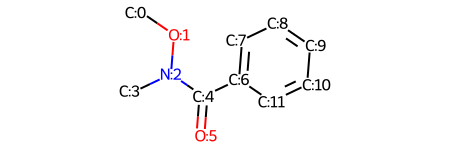

,reactants,products,rsig,psig,rsub,psub,rcen,pcen,rbond,pbond,rsig_clusters
11940,COCOc1ccc2c(c1C(=O)N(C)OC)OCO2,COCOc1ccc2c(c1C(C)=O)OCO2,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6]([CH...,[NH:8]([CH3:9])[O:10][CH3:11],[CH4:7],8,7,[[1.0]],[[1.0]],10525
34685,CCCCOc1cc(C(F)(F)F)ccc1C(=O)N(C)OC,CCCCOc1cc(C(F)(F)F)ccc1C=O,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[H:0],[NH:8]([CH3:9])[O:10][CH3:11],[H:0],8,0,[[1.0]],[[1.0]],10525
103016,CCCCC#Cc1ccccc1C(=O)N(C)OC,CCCCC#Cc1ccccc1C(=O)Cc1ccccc1,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[NH:8]([CH3:9])[O:10][CH3:11],[CH3:8][c:9]1[cH:10][cH:11][cH:12][cH:13][cH:14]1,8,8,[[1.0]],[[1.0]],10525
241912,CCCCNc1cc(F)ccc1C(=O)N(C)OC,CCCCNc1cc(F)ccc1C=CC(=O)OC,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[CH:6]=[C...,[CH:6](=[O:7])[N:8]([CH3:9])[O:10][CH3:11],[CH2:6]=[CH:7][C:8](=[O:9])[O:10][CH3:11],6,6,[[1.0]],[[1.0]],10525
337700,COc1cc(N)c(Cl)cc1C(=O)N(C)OC,COc1cc(N)c(Cl)cc1C(=O)CCCCCl,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[NH:8]([CH3:9])[O:10][CH3:11],[CH3:8][CH2:9][CH2:10][CH2:11][Cl:12],8,8,[[1.0]],[[1.0]],10525
365338,CCCCC#Cc1ccccc1C(=O)N(C)OC,CCCCC#Cc1ccccc1C(=O)Cc1ccc(F)cc1,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[NH:8]([CH3:9])[O:10][CH3:11],[CH3:8][c:9]1[cH:10][cH:11][c:12]([F:13])[cH:1...,8,8,[[1.0]],[[1.0]],10525
408155,CCCCC#Cc1ccccc1C(=O)N(C)OC,CCCCC#Cc1ccccc1C(=O)Cc1ccc(OC)cc1,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[cH:0]1[cH:1][cH:2][cH:3][cH:4][c:5]1[C:6](=[O...,[NH:8]([CH3:9])[O:10][CH3:11],[CH3:8][c:9]1[cH:10][cH:11][c:12]([O:13][CH3:1...,8,8,[[1.0]],[[1.0]],10525


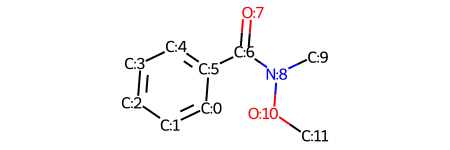

In [8]:
for key in certificate_to_cluster_id_dict:
    clusters = certificate_to_cluster_id_dict[key]
    print(len(clusters))
    print(clusters)
    
    for c in clusters[:10]:
        temp_df = dataset[dataset["rsig_clusters"] == c]
        display(temp_df)
        for i in range(temp_df.shape[0]):
#             print("Mol")
#             display(Chem.MolFromSmiles(temp_df.iloc[i]["reactants"]))
#             print("rsub")
#             display(Chem.MolFromSmiles(temp_df.iloc[i]["rsub"]))
#             print("sigs")
            display(Chem.MolFromSmiles(temp_df.iloc[i]["rsig"]))
#             display(Chem.MolFromSmiles(temp_df.iloc[i]["psig"]))
#             print()
#             print()
#             print()
            break
#         break
    break

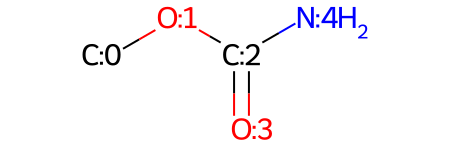

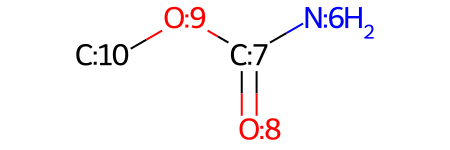

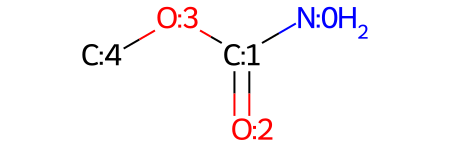

In [72]:
for key in list(certificate_to_cluster_id_dict.keys())[9:]:
    for i in certificate_to_cluster_id_dict[key]:
        display(Chem.MolFromSmiles(dataset[dataset["rsig_clusters"]==i].iloc[0]["rsub"]))
    break

# Action searching

The action searching algorithm has following steps:  
1. Find cut vertices
2. For each connected component + cut vertex, do index search on rsub
3. If MatchFound(), do substructure match on rsig

In [99]:
def mol_with_atom_index( mol ):
    mol = Chem.Mol(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

In [116]:
from rdkit.Chem import rdMMPA

In [123]:
m = Chem.MolFromSmiles('c1ccccc1OC')
frags = rdMMPA.FragmentMol(m, resultsAsMols=True)

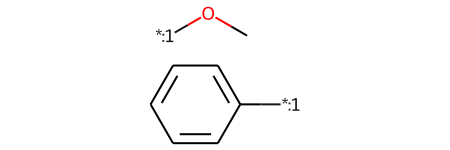

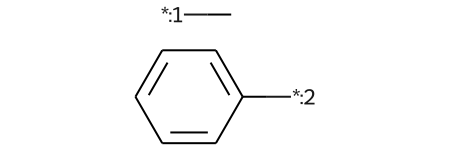

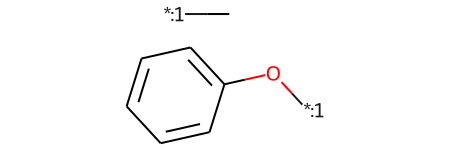

In [124]:
for frag in frags:
    display(frag[-1])

In mol


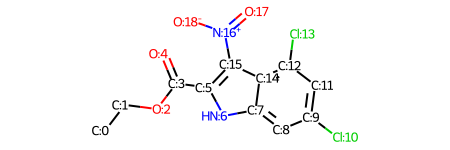

Rsub


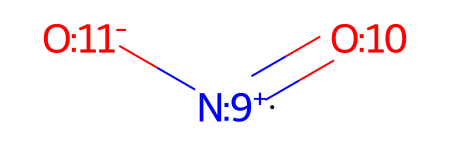

Rsig


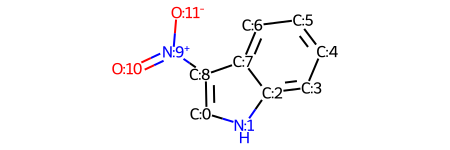

Candidate


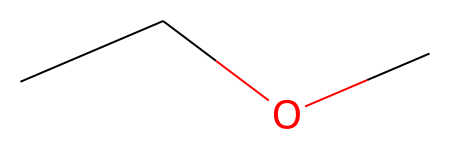

Candidate


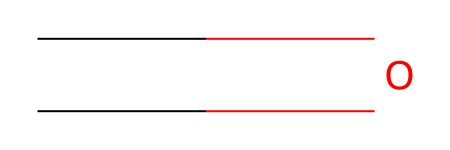

Candidate


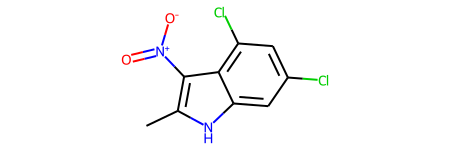

Candidate


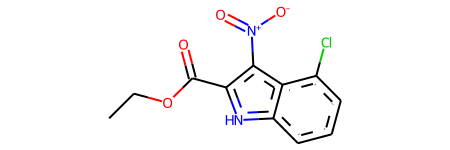

Candidate


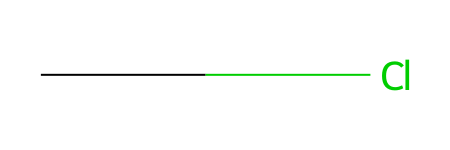

Candidate


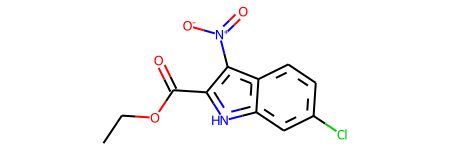

Candidate


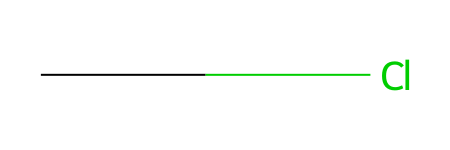

Candidate


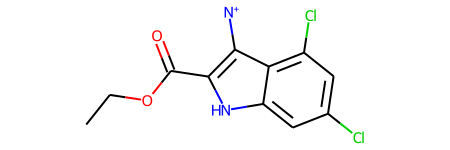

Candidate


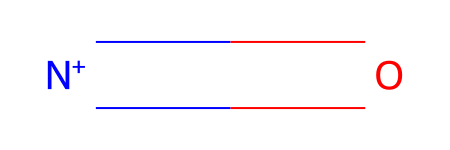

Candidate


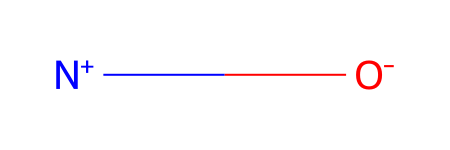

Candidate


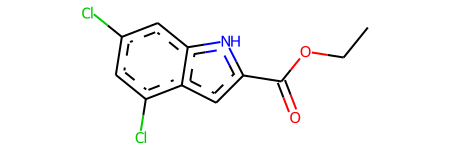

Candidate


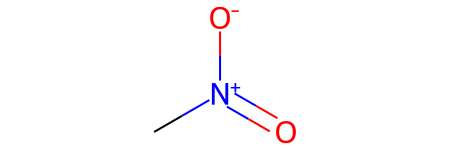

Candidate


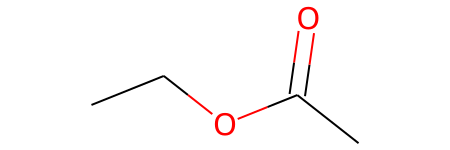

Candidate


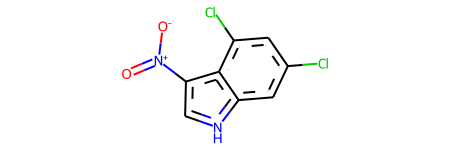

Candidate


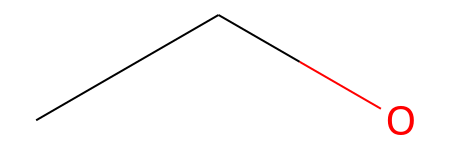

Candidate


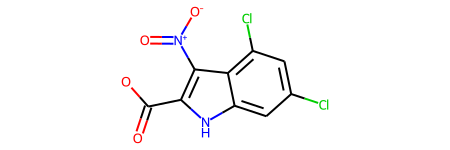

Candidate


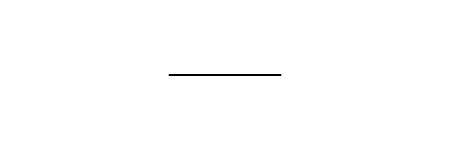

Candidate


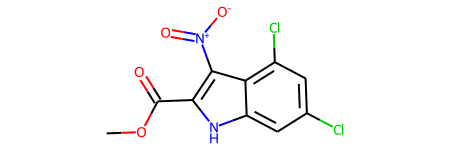

[13191, 21332, 63487, 1364]
CPU times: user 8.22 s, sys: 12.1 ms, total: 8.24 s
Wall time: 8.22 s


In [139]:
%%time

# For a new molecule, let's find all possible actions applicable
i = 200
in_mol = Chem.MolFromSmiles(dataset.iloc[i]["reactants"])
rsub = Chem.MolFromSmiles(dataset.iloc[i]["rsub"])
rsig = Chem.MolFromSmiles(dataset.iloc[i]["rsig"])

print("In mol")
display(mol_with_atom_index(in_mol))
print("Rsub")
display(rsub)
print("Rsig")
display(rsig)

def verify_action_applicability(mol, cluster_id):
    rsig = Chem.MolFromSmiles(dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rsig"])
    rcen = dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rcen"]
    rbond = dataset[dataset["rsig_clusters"]==cluster_id].iloc[0]["rbond"]
    
    # Check if the cluster rsig is in mol
    if not mol.HasSubstructMatch(rsig):
        return False
    
    # Check if the rcen matches
    match = mol.GetSubstructMatch(rsig)
    
    cand_rcen = match[rcen]
    cand_atom = mol.GetAtomWithIdx(cand_rcen)
    neighbors = list(map(lambda x: x.GetIdx(), cand_atom.GetNeighbors()))
    if not set(neighbors) - set(match):
        return False

    return True
    
def get_mol_from_index_list(mol, indices):
    rw = Chem.RWMol(mol)
    rw.BeginBatchEdit()
    for idx in set(list(range(mol.GetNumAtoms()))) - set(indices):
        rw.RemoveAtom(idx)
    rw.CommitBatchEdit()
    return Chem.Mol(rw)
    

# For each cut vertex, we find two disconnected components and search the smaller one in our index
G = nx.from_numpy_matrix(Chem.GetAdjacencyMatrix(in_mol))
applicable_actions = []

for x in nx.articulation_points(G):
    # Remove atom (not directly, otherwise the index resets)
    # First remove bonds to x
    mw = Chem.RWMol(in_mol)
    Chem.Kekulize(mw, clearAromaticFlags=True)
    for n in mw.GetAtomWithIdx(x).GetNeighbors():
        mw.RemoveBond(x, n.GetIdx())
    
    # Find fragments
    mol_frags = list(Chem.rdmolops.GetMolFrags(mw))
    
    # Remove x from fragments
    mol_frags.remove((x,))
    
    
    # For each fragment, add x and extract sub-molecule and search
    for frag in mol_frags:
        indices = [x] + list(frag)
        candidate = get_mol_from_index_list(in_mol, indices)
        print("Candidate")
        display(candidate)

        # get certificate and search in rsub
        cand_certi = get_mol_certificate(candidate)
        if cand_certi in certificate_to_cluster_id_dict:
            # Verify rsig
            for cluster_id in certificate_to_cluster_id_dict[cand_certi]:
#                 print("Verification...", cluster_id)
                if verify_action_applicability(in_mol, cluster_id):
                    applicable_actions.append(cluster_id)
                
print(applicable_actions)

Input molecule


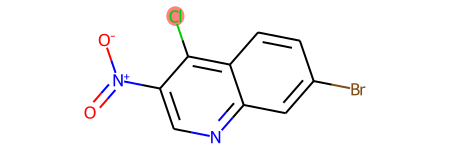

Random rsig chosen (rcen = 0)


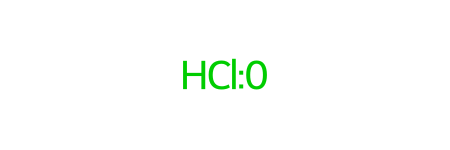

Random psig chosen (pcen = 0)


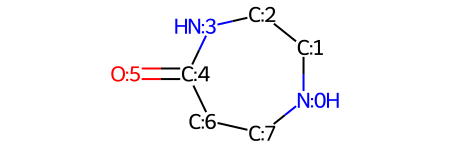

In [331]:
# Pick a random action from all the possible ones
temp_df = dataset[dataset["rsig_clusters"].isin(applicable_actions)]
random_action = temp_df.iloc[int(np.random.random()*temp_df.shape[0])]

print("Input molecule")
display(in_mol)
print(f"Random rsig chosen (rcen = {random_action['rcen']})")
display(Chem.MolFromSmiles(random_action["rsig"]))
print(f"Random psig chosen (pcen = {random_action['pcen']})")
display(Chem.MolFromSmiles(random_action["psig"]))

Input molecule with canditate matches


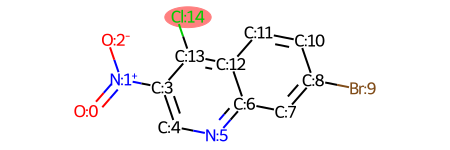

Input molecule without rsig


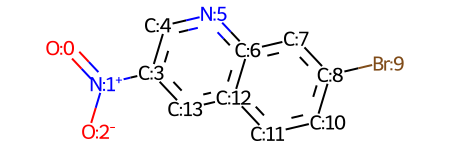

Input molecule with psig


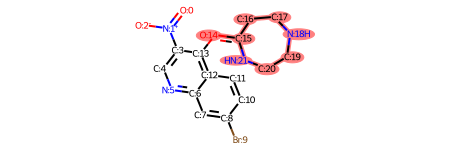

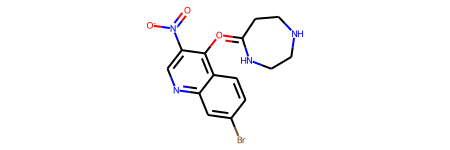

In [341]:
def mol_with_atom_index( mol ):
    '''
    draw molecule with index
    '''
    colored = False
    if hasattr(mol, "__sssAtoms"):
        sss = mol.__sssAtoms
        colored = True
    mol = Chem.Mol(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    if colored:
        mol.__sssAtoms = sss
    return mol

def smiles_without_atom_index( smiles ):
    '''
    Convert smiles with numbers to smiles without numbers
    '''
    mol = Chem.MolFromSmiles(smiles)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).ClearProp( 'molAtomMapNumber' )
    return Chem.MolToSmiles(mol)

def replace_signature(input_mol, rsig, rcen, rbond, psig, pcen, pbond):
    input_mol = Chem.Mol(input_mol)
    matches = input_mol.GetSubstructMatches(Chem.MolFromSmiles(rsig))
    # FIXME: Provide option to use more than just the first match
    match = matches[0]

    # Find the connecting atom idx
    connecting_atoms = []
    for atm_idx in match:
        atom = input_mol.GetAtomWithIdx(atm_idx)
        neighbors = atom.GetNeighbors()
        neighbors_indices = list(map(lambda x: x.GetIdx(), neighbors))
        connecting_atoms.extend(list(map(lambda x: input_mol.GetAtomWithIdx(x), set(neighbors_indices) - set(match))))
    print(connecting_atoms)
    pcen_atom = input_mol.GetAtomWithIdx(int(pcen))
        
    print("Input molecule with canditate matches")
    display(mol_with_atom_index(input_mol))
    rwmol = Chem.RWMol(input_mol)
    for idx in match:
        rwmol.RemoveAtom(idx)
    print("Input molecule without rsig")
    display(mol_with_atom_index(rwmol))

    original_num_atoms = rwmol.GetNumAtoms()
    rwmol.InsertMol(Chem.MolFromSmiles(smiles_without_atom_index(psig)))
#     display(mol_with_atom_index(rwmol))
    
    for c_atom in connecting_atoms:
#         print(c_atom.GetIdx(), pcen_atom.GetIdx()+original_num_atoms)
        rwmol.AddBond(c_atom.GetIdx(), pcen_atom.GetIdx()+original_num_atoms, Chem.BondType.SINGLE)
    
    output_mol = Chem.Mol(rwmol)
    
    temp_mol = Chem.Mol(output_mol)
    temp_mol.GetSubstructMatch(Chem.MolFromSmiles(psig))
    print("Input molecule with psig")
    display(mol_with_atom_index(temp_mol))
    
#     display(Chem.MolFromSmiles(psig))
#     print(pcen)
    
    return output_mol
    
replace_signature(in_mol, random_action["rsig"], random_action["rcen"], [], random_action["psig"], random_action["pcen"], [])

In [249]:
temp_df

,reactants,products,rsig,psig,rcen,pcen,rbond,pbond,rsig_clusters


In [13]:
mol = Chem.MolFromSmiles("CONC")

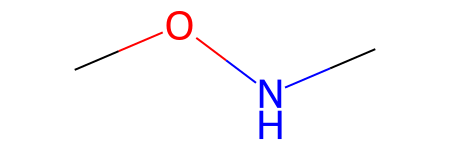

In [14]:
mol

In [152]:
Chem.GetAdjacencyMatrix(mol)

array([[0, 1, 0, 0],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [0, 0, 1, 0]], dtype=int32)

In [15]:
mol = Chem.MolFromSmiles("CC(C)C")

In [16]:
adj_mat = Chem.GetAdjacencyMatrix(mol)

# Create a ring for each atom with size = atomic_num
atom_nums = np.array([atom.GetAtomicNum() for atom in list(mol.GetAtoms())])
# atom_nums[atom_nums == 6] = 1
mat_list = []
for atn in atom_nums:
    new_mat = np.zeros(shape=(atn, atn), dtype=np.int8)
    for i in range(atn):
        new_mat[i, (i+1)%atn] = 1
    mat_list.append(new_mat)

# conbine the rings into a new adj mat
new_adj_mat = np.zeros(shape=(sum(atom_nums), sum(atom_nums)), dtype=np.int8)
idx = 0
for i in range(len(atom_nums)):
    new_adj_mat[idx:idx+atom_nums[i], idx:idx+atom_nums[i]] = mat_list[i]
    idx += atom_nums[i]
    
# add original last connections
idx = 0
for i, a_i in enumerate(np.cumsum(atom_nums)):
    for j, a_j in enumerate(np.cumsum(atom_nums)):
        new_adj_mat[a_i-1, a_j-1] = adj_mat[i, j]
#         print(a_i-1, a_j-1, adj_mat[i, j])

In [17]:
for row in new_adj_mat:
    print(row)

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


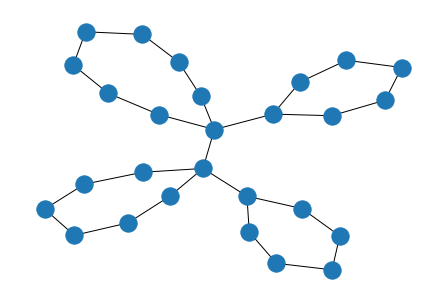

In [156]:
import networkx as nx
G = nx.from_numpy_matrix(new_adj_mat)

nx.draw_kamada_kawai(G)